In [238]:
using GLM
using DataFrames
using Random
using Parquet
import YAML
using Plots
using CSV
import OrderedCollections: OrderedDict
using StatsBase
import Term: tprintln
import HypothesisTests: EqualVarianceTTest, pvalue
using MultipleTesting

using MyterialColors
import MyterialColors: blue, red

# import Pkg
# Pkg.add(url="https://github.com/JuliaPlots/VennEuler.jl.git")
using VennEuler

colors = OrderedDict(
    # "complete" => "black",
    # "missing_s" => teal_dark,
    # "missing_apex_distance" => green_dark,
    # "missing_curv_5cm" => teal,
    # "missing_curv_15cm" => teal,
    # "missing_curv_25cm" => teal,
    # "missing_curv_class" =>  teal_light,
    # "missing_domega_1000ms" => indigo_dark,
    # "missing_domega_500ms" => indigo_dark,
    # "missing_domega_250ms" => indigo_dark,
    # "missing_omega" => blue,
    # "missing_Δomega_class" => indigo_darker,
    # "missing_omega_squared" => blue,
    # "missing_omega_class" => blue_light,
    # "missing_dv_1000ms" => pink_dark,
    # "missing_dv_500ms" => pink_dark,
    # "missing_dv_250ms" => pink_dark,
    # "missing_v" => pink,
    # "missing_v_squared" => pink,
    # "missing_speed_class" => salmon_dark,
    # "missing_Δspeed_class" => red,
    
    
    "complete" => "black",
    "with_s" => teal_dark,
    "with_apex_distance" => green_dark,
    "with_curv_5cm" => teal,
    "with_curv_15cm" => teal,
    "with_curv_25cm" => teal,
    "with_curv_class" =>  teal_light,
    "with_domega_1000ms" => indigo_dark,
    "with_domega_500ms" => indigo_dark,
    "with_domega_250ms" => indigo_dark,
    "with_omega" => blue,
    "with_Δomega_class" => indigo_darker,
    "with_omega_squared" => blue,
    "with_omega_class" => blue_light,
    "with_dv_1000ms" => pink_dark,
    "with_dv_500ms" => pink_dark,
    "with_dv_250ms" => pink_dark,
    "with_v" => pink,
    "with_v_squared" => pink,
    "with_speed_class" => salmon_dark,
    "with_Δspeed_class" => red,    
    
)


include(raw"C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\glm\glm_utils.jl");

REGION = "CUN/PPN"

metadata = filter(kv -> kv.second["region"] == REGION, metadata)

╭──── Dict {Any, Any}  ───────────────────────────────────────────────────────╮
│                                                                             │
│   {String} │ FC_211027_BAA110516_hairpin... => Dict("unit_data" ... ...     │
│   {String} │ FC_210831_BAA1110281_hairpi... => Dict("unit_data" ... ...     │
│   {String} │ FC_210820_BAA1110281_hairpi... => Dict("unit_data" ... ...     │
│   {String} │ FC_210831_BAA1110281_hairpi... => Dict("unit_data" ... ...     │
│   {String} │ FC_210830_BAA1110281_hairpi... => Dict("unit_data" ... ...     │
│   {String} │ FC_210906_BAA1110281_hairpi... => Dict("unit_data" ... ...     │
│   {String} │ FC_220120_BAA110517_hairpin... => Dict("unit_data" ... ...     │
│   {String} │ FC_210716_AAA1110750_r6_hai... => Dict("unit_data" ... ...     │
│   {String} │ FC_210820_BAA1110281_hairpi... => Dict("unit_data" ... ...     │
│   {String} │ FC_220120_BAA110517_hairpin... => Dict("unit_data" ... ...     │
│      ⋮     │               ⋮          

## Load GLM results
Load metadata of which cells were ran and their correlations

In [239]:
fitted = filter(kv -> kv.second["glm_fitted"], metadata)
@info "Fitted $(length(fitted))/$(length(metadata)) units"

formulas = generate_formulas()

for (k,v) in fitted
    # get the pearson correlations
    v["correlations"] = DataFrame(CSV.File(
        joinpath(v["folder"], "correlations.csv")
    ))

    # get the correlations of the shuffled data
    v["shuffled_correlations"] = DataFrame(CSV.File(
        joinpath(v["folder"], "shuffled_correlations.csv")
    ))

    # get a `FittedModel`
    try
        v["model"] = load_fitted(v, "complete", formulas)
    catch
        v["model"] = nothing
    end
end

nomodel = filter(kv -> isnothing(kv.second["model"]), fitted) |> keys |> collect
length(nomodel) > 0 && @info "No model fitted for $(length(nomodel)) units - revise metadata";

@Info (Main):  Fitted 172/172 units 
  ╰──────────────────────────────────────────────── 
                      Wed, 22 Jun 2022 11:27:31 


## Identify tuned
Look for units whose pearson correlation in the full mode is above the 99th CI of the shuffled correlations

In [240]:
to_ignore = []
for (k, unit) in fitted
    cbest = mean(unit["correlations"][:, "complete"])
    cshuff = max.(eachcol(unit["shuffled_correlations"])...)

    threshold = 0.0
    try
        threshold = percentile(cshuff, 99.9) 
    catch
        @info "nans in correlation"
        push!(to_ignore, k)
        continue
    end

    unit["correlation_threshold"]  = threshold
    unit["tuned"] = cbest > threshold
end

@info "something went wrong for $(length(to_ignore)) units" 

tuned = filter(kv -> kv.first ∉ to_ignore, fitted)
tuned = filter(kv -> kv.second["tuned"], tuned)
tuned = OrderedDict(sort(collect(tuned), by = kv->kv.second["best_corr"]))
@info "Tuned $(length(tuned))/$(length(fitted)) units"

@Info (Main.top-level scope):  nans in correlation 
  ╰──────────────────────────────────────────────── 
                      Wed, 22 Jun 2022 11:27:33 
@Info (Main):  something went wrong for 1 units 
  ╰──────────────────────────────────────────────── 
                      Wed, 22 Jun 2022 11:27:34 
@Info (Main):  Tuned 73/172 units 
  ╰──────────────────────────────────────────────── 
                      Wed, 22 Jun 2022 11:27:34 


plot a single tuned unit

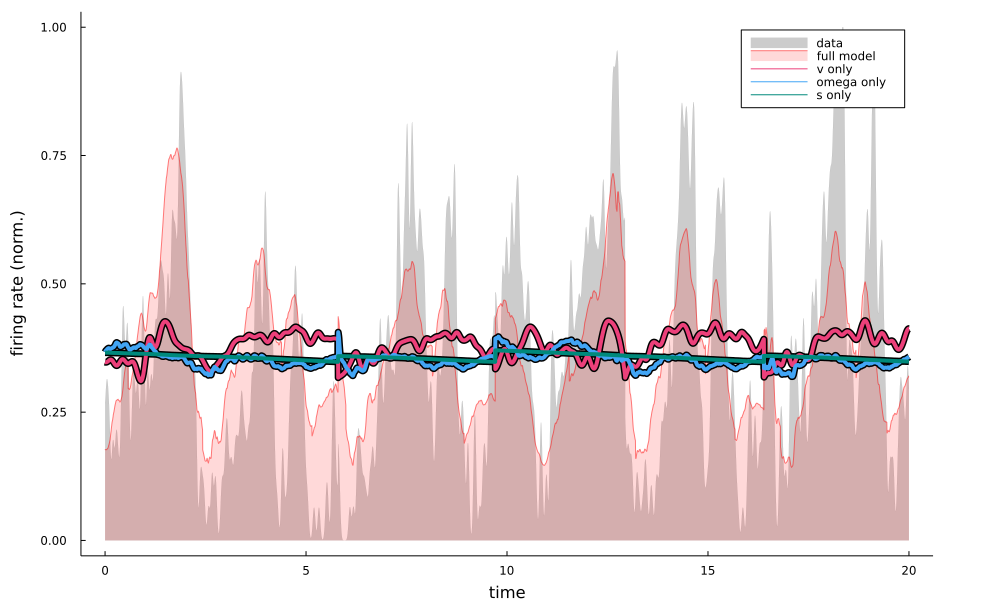

In [251]:
unit = collect(values(tuned))[end]
unit_data = load_data(unit)


# nov_model = load_fitted(unit, "missing_omega_class")
# ŷ_nov = predict(nov_model, unit_data)

x = load_data(unit["model"])
ŷ = predict(unit["model"], x)
y = x.p_spike

t0 = 5_001
t1 = t0 + 4_000

time = collect(0:(t1-t0)) / 200  # time in seconds

plot(ylabel="firing rate (norm.)", xlabel="time", size=(1000, 600), grid=false,
left_margin = 5Plots.mm, right_margin = 15Plots.mm,
)
plot!(time,  y[t0:t1], fillrange =0, fillcolor=:black, fillalpha=.2, color="black", lebel="data", alpha=.5, lw=0, label="data")
plot!(time,  ŷ[t0:t1], fillrange =0, fillcolor=:red, fillalpha=.15, lw=1, alpha=.5, label="full model", color="red")

for variable in ("v", "omega", "s")
    mod = load_fitted(unit, "with_$variable")
    ŷ_nov = predict(mod, unit_data)
    plot!(time,  ŷ_nov[t0:t1], lw=7, alpha=1, label=nothing, color=:black)
end


for variable in ("v", "omega", "s")
    mod = load_fitted(unit, "with_$variable")
    ŷ_nov = predict(mod, unit_data)
    plot!(time,  ŷ_nov[t0:t1], lw=4, alpha=1, label="$variable only", color=colors["with_$variable"])
end

plot!()


## Variables tuning

Start by plotting for a unit the pearson correlation of each model and compare it to the full model.

D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys\GLM\FC_220119_BAA110517_hairpin_unit_344

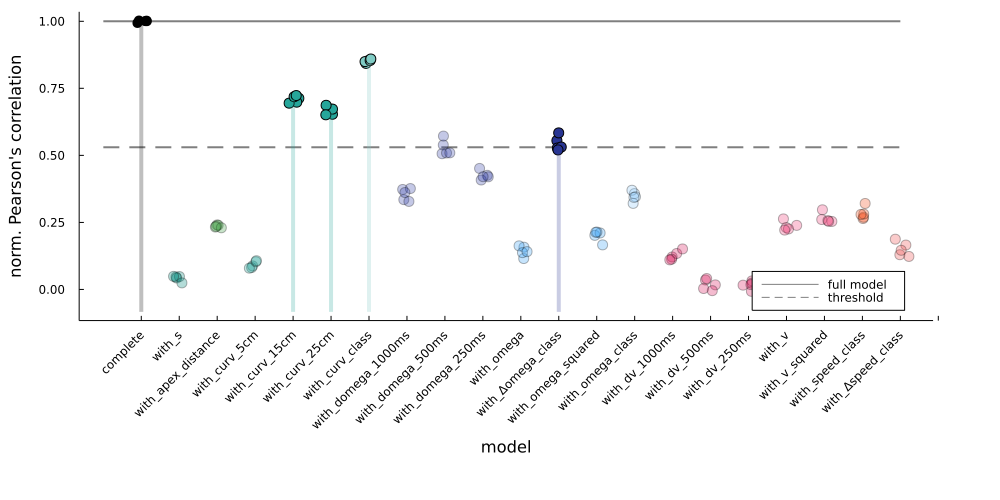

In [252]:
unit = collect(values(tuned))[end]
print(unit["folder"])
mean_corr = OrderedDict(k => v for (k,v) in zip(names(unit["correlations"]), mean.(eachcol(unit["correlations"]))))
# threshold = .2

complete_model_corr = mean_corr["complete"]
corrs = OrderedDict(k => v./complete_model_corr for (k,v) in zip(names(unit["correlations"]), values(eachcol(unit["correlations"]))))

# get pvalues betweeen all models correlations and complete
filtered_keys = filter!(k -> k != "complete", collect(keys(corrs)))
pvals = map(
    k -> pvalue(
        EqualVarianceTTest(
            values(corrs[k]),
            values(corrs["complete"])
        )
    ),
    filtered_keys
)
pvals = Dict( k => p for (k, p) in zip(filtered_keys, adjust(pvals, Bonferroni())))


cshuff = mean.(eachcol(unit["shuffled_correlations"]))
threshold = percentile(cshuff, 95) / complete_model_corr

# plot
plot()
plot!([0, length(mean_corr)], [1, 1], color="black", alpha=.5, lw=2, label="full model")
plot!([0, length(mean_corr)], [threshold, threshold], color="black", linestyle=:dash, alpha=.5, lw=2, label="threshold")

for (i, model) in enumerate(keys(colors))
    corr = mean_corr[model] ./ complete_model_corr
    # istuned = corr <= tuning_th
    # istuned = model == "complete" ? true : pvals[model] <= 0.05
    istuned = corr >= threshold

    scatter!(ones(5)*i .+ 0.1randn(5), corrs[model], color=colors[model], ms=6, alpha= istuned ? 1 : .3, label=nothing)
    # scatter!([i], [corr], label=nothing)
    istuned && plot!(
        [i, i],
        [min(values(mean_corr)...) / complete_model_corr - .1, corr],
        color=colors[model],
        alpha=.25,
        lw=4,
        label=nothing
    )
end

plot!(   
    xticks = (
        1:length(mean_corr)+1,
        keys(colors)
    ), 
    xrotation = 45,
    ylabel = "norm. Pearson's correlation",
    xlabel = "model",
    grid=false,
    size=(1000, 500),
    left_margin = 5Plots.mm, right_margin = 15Plots.mm,
    bottom_margin = 25Plots.mm,
    legend=:bottomright
    )



Get all tuning for all units

In [244]:
variables_tuning = Dict{String, Vector{Bool}}(k => [] for k in keys(colors))

for (name, unit) in tuned
    # get mean pearson correlation of each model and threshold
    mean_corr = OrderedDict(k => v for (k,v) in zip(names(unit["correlations"]), mean.(eachcol(unit["correlations"]))))   
    complete_model_corr = mean_corr["complete"]
    # corrs = OrderedDict(k => v./complete_model_corr for (k,v) in zip(names(unit["correlations"]), values(eachcol(unit["correlations"]))))

    cshuff = mean.(eachcol(unit["shuffled_correlations"]))
    threshold = percentile(cshuff, 95) / complete_model_corr
    
    for model in keys(colors)
        corr = mean_corr[model] ./ complete_model_corr
        istuned = corr >= threshold
        push!(variables_tuning[model],  istuned)

    # # get pvalues with bonferroni
    # filtered_keys = filter!(k -> k != "complete", collect(keys(corrs)))
    # pvals = map(
    #     k -> pvalue(
    #         EqualVarianceTTest(
    #             values(corrs[k]),
    #             values(corrs["complete"])
    #         )
    #     ),
    #     filtered_keys
    # )
    # pvals = Dict( k => p for (k, p) in zip(filtered_keys, adjust(pvals, Bonferroni())))
    
    # # get which models are tuned
    # for model in keys(colors)    
    #     # corr, pval = mean_corr[model], pvals[model]
    #     vtuned = model == "complete" ? true : pvals[model] <= 0.05
    #     push!(variables_tuning[model],  vtuned)
    end
end

variables_tuning = DataFrame(variables_tuning);

In [245]:
ntuned_var = Dict(k=>sum(variables_tuning[:, k]) for k in keys(colors))
var_classes = ["with_curv_class", "with_omega_class", "with_speed_class", "with_Δspeed_class", "with_Δomega_class"]
classes_names = ["Position/curvature class", "angular velocity class", "speed class", "future speed class", "future angular velocity class"]

# get percentage of units tuned to each class of variables
for (n, var) in zip(classes_names, var_classes)
    # print number of units tuned to class vs total
    ntuned = ntuned_var[var]
    ntotal = length(tuned)
    tprintln("{green}$(ntuned){/green}/$(ntotal) ($(round(ntuned/ntotal * 100; digits=2))%) units tuned to {bold white}$(n){/bold white}";)
end

12/73 (16.44%) units tuned to Position/curvature class 
10/73 (13.7%) units tuned to angular velocity class 
54/73 (73.97%) units tuned to speed class 
13/73 (17.81%) units tuned to future speed class 
1/73 (1.37%) units tuned to future angular velocity class 


get how many units are tuned to > 1 class of variables

Get how many units are tuned to `speed`, `omega` and spatial info.

In [246]:
import OrderedCollections: OrderedDict
import Term: Table, Panel, hLine, cvstack
import Term: highlight

N = size(variables_tuning, 1)
count_perc(x) = highlight("$(x)/$(N) ($(round(x/N * 100; digits=2))%)")

tb(x) = Table(
    x;
    header_style="bold white on_black",
    box=:NONE, style="blue"
)

classes = ["with_v", "with_v_squared", "with_dv_250ms", "with_dv_500ms", "with_dv_1000ms", "with_Δspeed_class"]
cnames = ["speed", "speed²", "Δv 250ms", "Δv 500ms", "Δv 1000ms", "Δspeed"]


V = OrderedDict(
    n => count_perc(sum(variables_tuning[:, k])) for (n, k) in zip(cnames, classes)
) |> tb


classes = ["with_omega", "with_omega_squared", "with_domega_250ms", "with_domega_500ms", "with_domega_1000ms", "with_Δomega_class"]
cnames = ["ang. velocity","ω²", "Δω 250ms", "Δω 500ms", "Δω 1000ms", "Δω"]

O = OrderedDict(
    n => count_perc(sum(variables_tuning[:, k])) for (n, k) in zip(cnames, classes)
) |> tb


classes = ["with_s", "with_apex_distance", "with_curv_5cm", "with_curv_15cm", "with_curv_25cm"]
cnames = ["arena location", "apex distance", "curvature at 5 cm", "curvature at 15 cm", "curvature at 25 cm"]

K = OrderedDict(
    n => count_perc(sum(variables_tuning[:, k])) for (n, k) in zip(cnames, classes)
) |> tb


Panel(
    cvstack(Panel(V; fit=false, width=150, title="SPEED", title_style="bold red", title_justify=:center, justify=:center, box=:NONE), 
    hLine(170; box=:HEAVY), "",
    Panel(O; fit=false, width=150, title="ANGULAR VELOCITY", title_style="bold red", title_justify=:center, justify=:center, box=:NONE), 
    hLine(170; box=:HEAVY), "",
    Panel(K; fit=false, width=150, title="POSITION", title_style="bold red", title_justify=:center, justify=:center, box=:NONE));
    fit=false, width=180, justify=:center
)

╭──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                       SPEED                                                                                      │
│                                                                                                                                                                                  │
│                                        speed              speed²           Δv 250ms         Δv 500ms         Δv 1000ms            Δspeed                                         │
│                                                                                                                                                                                  │
│                                    40/73 (54.79%)     36/73 (49.32%)     1/73 (1.37%)     2/7

Get how many units are tuned to speed/ang vel now, in the future or both

In [247]:
speed_tuned = variables_tuning[:, "with_v"] .|| variables_tuning[:, "with_v_squared"]
Δspeed_tuned = variables_tuning[:, "with_Δspeed_class"]
both_tuned = speed_tuned .&& Δspeed_tuned

Dict(
    :speed=> count_perc(sum(speed_tuned)),
    :Δspeed=> count_perc(sum(Δspeed_tuned)),
    :both=> count_perc(sum(both_tuned))
)

╭──── Dict {Symbol, String}  ────────────────────────╮
│                                                    │
│   {Symbol} │  both  => 13/73 (17.81%) │ {String}   │
│   {Symbol} │ Δspeed => 13/73 (17.81%) │ {String}   │
│   {Symbol} │ speed  => 40/73 (54.79%) │ {String}   │
│                                                    │
╰──────────────────────────────────────── 3 items ───╯


In [248]:
speed_tuned = variables_tuning[:, "with_omega"] .|| variables_tuning[:, "with_omega_squared"]
Δspeed_tuned = variables_tuning[:, "with_Δomega_class"]
both_tuned = speed_tuned .&& Δspeed_tuned

Dict(
    :ω=> count_perc(sum(speed_tuned)),
    :Δω=> count_perc(sum(Δspeed_tuned)),
    :both=> count_perc(sum(both_tuned))
)

╭──── Dict {Symbol, String}  ─────────────────────╮
│                                                 │
│   {Symbol} │ both =>  0/73 (0.0%)  │ {String}   │
│   {Symbol} │  Δω  => 1/73 (1.37%)  │ {String}   │
│   {Symbol} │  ω   => 9/73 (12.33%) │ {String}   │
│                                                 │
╰───────────────────────────────────── 3 items ───╯


In [249]:
apex_distance_tuning = variables_tuning[:, "with_apex_distance"] 
curv_tuning = variables_tuning[:, "with_curv_5cm"] .|| variables_tuning[:, "with_curv_15cm"] .|| variables_tuning[:, "with_curv_25cm"]
s_tuning = variables_tuning[:, "with_s"]
any_tuned = curv_tuning .&& s_tuning .&& apex_distance_tuning

Dict(
    :curv_tuning=> count_perc(sum(curv_tuning)),
    :s_tuning=> count_perc(sum(s_tuning)),
    :apex_distance=> count_perc(sum(apex_distance_tuning)),
)

╭──── Dict {Symbol, String}  ──────────────────────────────╮
│                                                          │
│   {Symbol} │ apex_distance => 3/73 (4.11%)  │ {String}   │
│   {Symbol} │   s_tuning    => 5/73 (6.85%)  │ {String}   │
│   {Symbol} │  curv_tuning  => 9/73 (12.33%) │ {String}   │
│                                                          │
╰────────────────────────────────────────────── 3 items ───╯
